# EDB: Pin to Pin project

This example demonstrates the use of the Electronics
Database (EDB) interface to create a layout using the BOM and
a configuration file.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile

import ansys.aedt.core

import pyedb
from pyedb.misc.downloads import download_file

Download the AEDB file and copy it to a temporary folder.

In [2]:
temp_dir = tempfile.TemporaryDirectory(suffix=".ansys")
target_aedb = download_file("edb/ANSYS-HSD_V1.aedb", destination=temp_dir.name)
print("Project folder is", target_aedb)

Project folder is C:\Users\ansys\AppData\Local\Temp\tmpoe77iwbe.ansys\edb/ANSYS-HSD_V1.aedb


## Launch EDB

Launch the ``pyedb.Edb`` class using EDB 2023 R2. Length units are SI.

In [3]:
# Select EDB version (change it manually if needed, e.g. "2025.1")
edb_version = "2025.2"
print(f"EDB version: {edb_version}")

edbapp = pyedb.Edb(target_aedb, edbversion=edb_version)

EDB version: 2025.2


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 12:21:21.876305


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 9.1001 seconds.


PyEDB INFO: EDB initialization completed in 9.1641 seconds.


## Import definitions

The definition file uses the [json](https://www.json.org/json-en.html) to
map layout part numbers to their corresponding models.

The model may be an RLC, S-parameter, or
[SPICE](https://en.wikipedia.org/wiki/SPICE) model definition.
Once imported, the definition is applied to the components in the layout.
In this example, the JSON file is in the ``*.aedb`` folder and has the following format:
``` json
{
    "SParameterModel": {
        "GRM32_DC0V_25degC_series": "./GRM32_DC0V_25degC_series.s2p"
    },
    "SPICEModel": {
        "GRM32_DC0V_25degC": "./GRM32_DC0V_25degC.mod"
    },
    "Definitions": {
        "CAPC1005X05N": {
            "Component_type": "Capacitor",
            "Model_type": "RLC",
            "Res": 1,
            "Ind": 2,
            "Cap": 3,
            "Is_parallel": false
        },
        "'CAPC3216X180X55ML20T25": {
            "Component_type": "Capacitor",
            "Model_type": "SParameterModel",
            "Model_name": "GRM32_DC0V_25degC_series"
        },
        "'CAPC3216X180X20ML20": {
            "Component_type": "Capacitor",
            "Model_type": "SPICEModel",
            "Model_name": "GRM32_DC0V_25degC"
        }
    }
}
```

The ``Edb.components.import_definitions()`` method imports the component definitions that map
electrical models to the components in the simulation model.

In [4]:
edbapp.components.import_definition(os.path.join(target_aedb, "1_comp_definition.json"))

True

## Import BOM

The bill of materials (BOM) file provides the list of all components
by reference designator, part name, component type, and nominal value.

Components that are not contained in the BOM are deactivated in the
simulation model.
This example saves the CSV file in the ``aedb`` folder.

```
+------------+-----------------------+-----------+------------+
| RefDes     | Part name             | Type      | Value      |
+============+=======================+===========+============+
| C380       | CAPC1005X55X25LL05T10 | Capacitor | 11nF       |
+------------+-----------------------+-----------+------------+
```

Having red the information in the BOM and definitions file, electrical models can be
assigned to all of the components in the simulation model.

In [5]:
edbapp.components.import_bom(
    os.path.join(target_aedb, "0_bom.csv"),
    refdes_col=0,
    part_name_col=1,
    comp_type_col=2,
    value_col=3,
)

PyEDB INFO: RLC properties for Component C380 has been assigned.


True

## Verify a Component

Component property allows to access all components instances and their property with
getters and setters.

In [6]:
comp = edbapp.components["C1"]
comp.model_type, comp.value

('RLC', 1.0000000000000001e-07)

## Check component definition

When an s-parameter model is associated to a component it will be available in
nport_comp_definition property.

In [7]:
edbapp.components.nport_comp_definition
edbapp.save_edb()

PyEDB INFO: Save Edb file completed in 0.1203 seconds.


True

## Configure the simulation setup

This step enables the following:

- Definition of the nets to include in the cutout region
- Cutout details
- Components to create the ports on
- Simulation settings

The ``Edb.new_simulaton_configuration()`` method returns an instance
of the ``SimulationConfiguration`` class.

In [8]:
sim_setup = edbapp.new_simulation_configuration()
sim_setup.solver_type = sim_setup.SOLVER_TYPE.SiwaveSYZ
sim_setup.batch_solve_settings.cutout_subdesign_expansion = 0.003
sim_setup.batch_solve_settings.do_cutout_subdesign = True
sim_setup.batch_solve_settings.use_pyaedt_cutout = True
sim_setup.ac_settings.max_arc_points = 6
sim_setup.ac_settings.max_num_passes = 5

sim_setup.batch_solve_settings.signal_nets = [
    "PCIe_Gen4_TX2_CAP_P",
    "PCIe_Gen4_TX2_CAP_N",
    "PCIe_Gen4_TX2_P",
    "PCIe_Gen4_TX2_N",
]
sim_setup.batch_solve_settings.components = ["U1", "X1"]
sim_setup.batch_solve_settings.power_nets = ["GND", "GND_DP"]
sim_setup.ac_settings.start_freq = "100Hz"
sim_setup.ac_settings.stop_freq = "6GHz"
sim_setup.ac_settings.step_freq = "10MHz"

## Implement the setup

The cutout and all other simulation settings are applied to the simulation model.

In [9]:
sim_setup.export_json(os.path.join(temp_dir.name, "configuration.json"))
edbapp.build_simulation_project(sim_setup)

PyEDB INFO: Building simulation project.


PyEDB INFO: Cutting out using method: 1


PyEDB INFO: Cutting out using method: 1


PyEDB INFO: -----------------------------------------


PyEDB INFO: Trying cutout with (0.003)*(1000.0)mm expansion size


PyEDB INFO: -----------------------------------------


PyEDB INFO: Cutout Multithread started.


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `signal_list` is deprecated for method `cutout`; use `signal_nets` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `reference_list` is deprecated for method `cutout`; use `reference_nets` instead.
  warnings.warn(


PyEDB INFO: Net clean up Elapsed time: 0m 1sec


PyEDB INFO: Correctly computed Extension at first iteration.


PyEDB INFO: Extent Creation Elapsed time: 0m 0sec


PyEDB INFO: 1984 Padstack Instances deleted. Elapsed time: 0m 1sec


PyEDB INFO: 444 Primitives deleted. Elapsed time: 0m 3sec


PyEDB INFO: 978 components deleted


PyEDB INFO: Deleted 470 components


PyEDB INFO: Single Pins components deleted Elapsed time: 0m 0sec


PyEDB INFO: Cutout completed. Elapsed time: 0m 5sec


PyEDB INFO: EDB file save completed in 0.0798 seconds.


PyEDB INFO: Cutout completed in 1 iterations with expansion size of (0.003)*(1000.0)mm Elapsed time: 0m 5sec


PyEDB INFO: Cutout processed.


PyEDB INFO: Deleting existing ports.


PyEDB INFO: No pins found on component Ansys.Ansoft.Edb.Cell.Hierarchy.Component for the net PCIe_Gen4_TX2_P


PyEDB INFO: No pins found on component Ansys.Ansoft.Edb.Cell.Hierarchy.Component for the net PCIe_Gen4_TX2_N


PyEDB INFO: No pins found on component Ansys.Ansoft.Edb.Cell.Hierarchy.Component for the net PCIe_Gen4_TX2_CAP_N


PyEDB INFO: No pins found on component Ansys.Ansoft.Edb.Cell.Hierarchy.Component for the net PCIe_Gen4_TX2_CAP_P


PyEDB INFO: Configuring analysis setup.


PyEDB INFO: Adding frequency sweep


PyEDB INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyEDB INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyEDB INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyEDB INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyEDB INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyEDB INFO: Padstack definition with zero plating ratio, defaulting to 20%


PyEDB INFO: Save Edb file completed in 0.0315 seconds.


True

## Display the cutout

Plot cutout once finished. The model is ready to simulate.

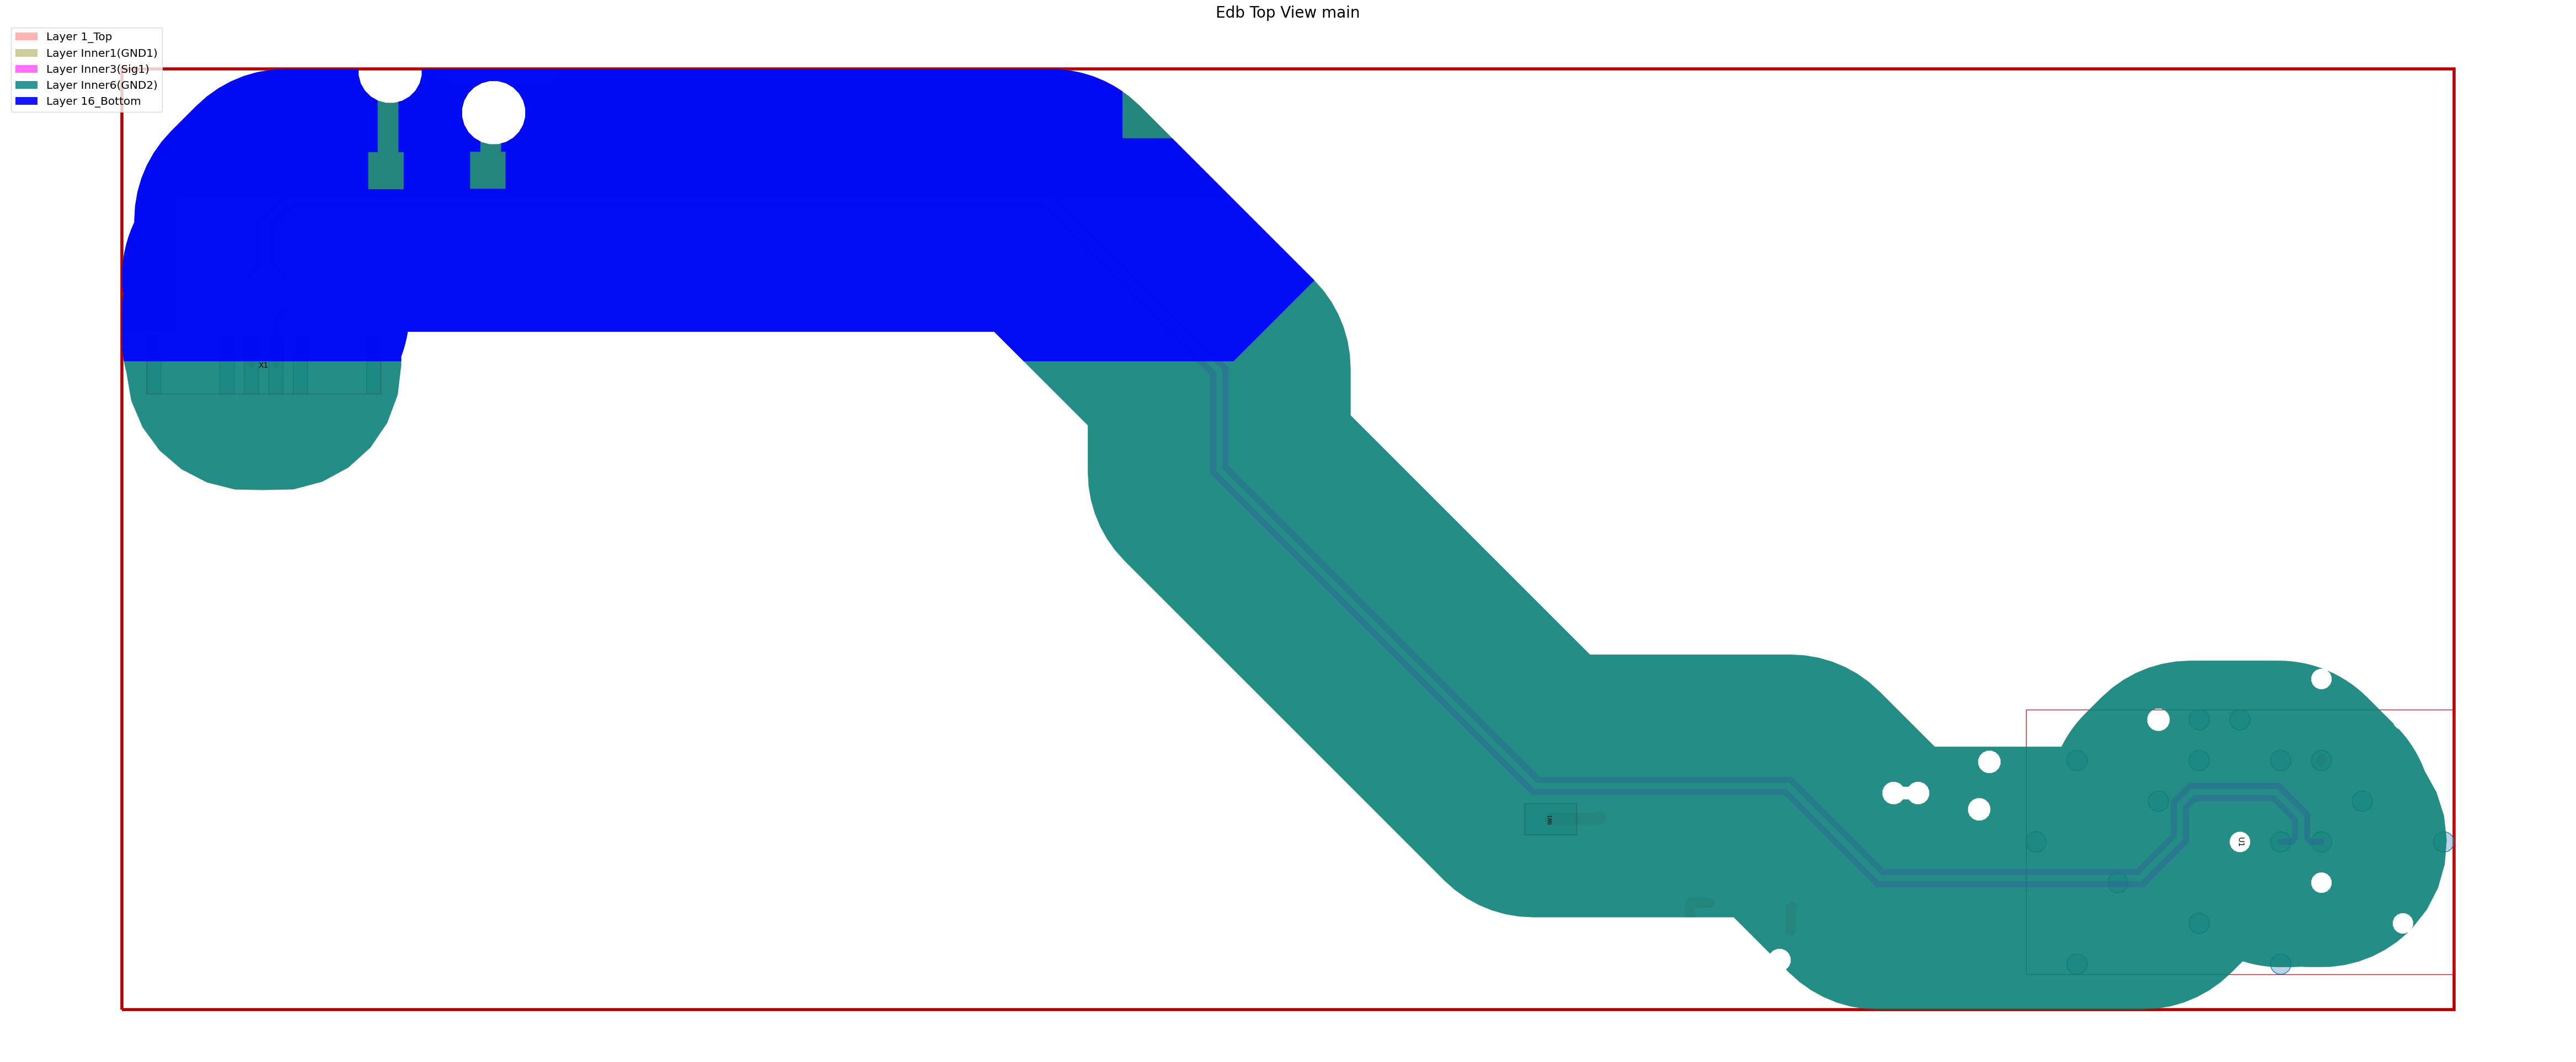

PyEDB INFO: Plot Generation time 0.768


(<Figure size 6000x3000 with 1 Axes>,
 <Axes: title={'center': 'Edb Top View main'}>)

In [10]:
edbapp.nets.plot(None, None)

## Save and close EDB

EDB is saved and re-opened in HFSS
3D Layout, where the HFSS simulation can be run.

In [11]:
edbapp.save_edb()
edbapp.close_edb()

PyEDB INFO: Save Edb file completed in 0.0436 seconds.


PyEDB INFO: Close Edb file completed in 0.0952 seconds.


True

## Open Electronics Desktop

The EDB is opened in AEDT Hfss3DLayout.

Set ``non_graphical=True`` to run the simulation in non-graphical mode.

In [12]:
aedt_version = edb_version

In [13]:
h3d = ansys.aedt.core.Hfss3dLayout(
    version=aedt_version,
    project=target_aedb,
    non_graphical=False,
    new_desktop=False,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_d03415e2-6ae5-4d92-bac4-858a9c44d7c3.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 3312.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmpoe77iwbe.ansys\edb/ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


## Analyze

This project is ready to solve.
Executing the following cell runs the HFSS simulation on the layout.

In [14]:
h3d.analyze()

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 36.0s


True

## View results

S-parameter data is loaded at the end of simulation.

In [15]:
solutions = h3d.post.get_solution_data()

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpoe77iwbe.ansys\edb\ANSYS-HSD_V1.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpoe77iwbe.ansys\edb\ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.30229854583740234


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Loading Modeler.


PyAEDT INFO: Modeler loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyEDB INFO: Star initializing Edb 12:22:38.321083


PyEDB INFO: Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.67.1


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


PyEDB INFO: Builder was initialized.


PyEDB INFO: open_edb completed in 0.0761 seconds.


PyEDB INFO: EDB initialization completed in 0.0792 seconds.


PyAEDT INFO: EDB loaded.


PyAEDT WARNING: No report category provided. Automatically identified Standard


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.0
Time to initialize solution data:0.0647428035736084


## Plot results

Plot S-Parameter data.

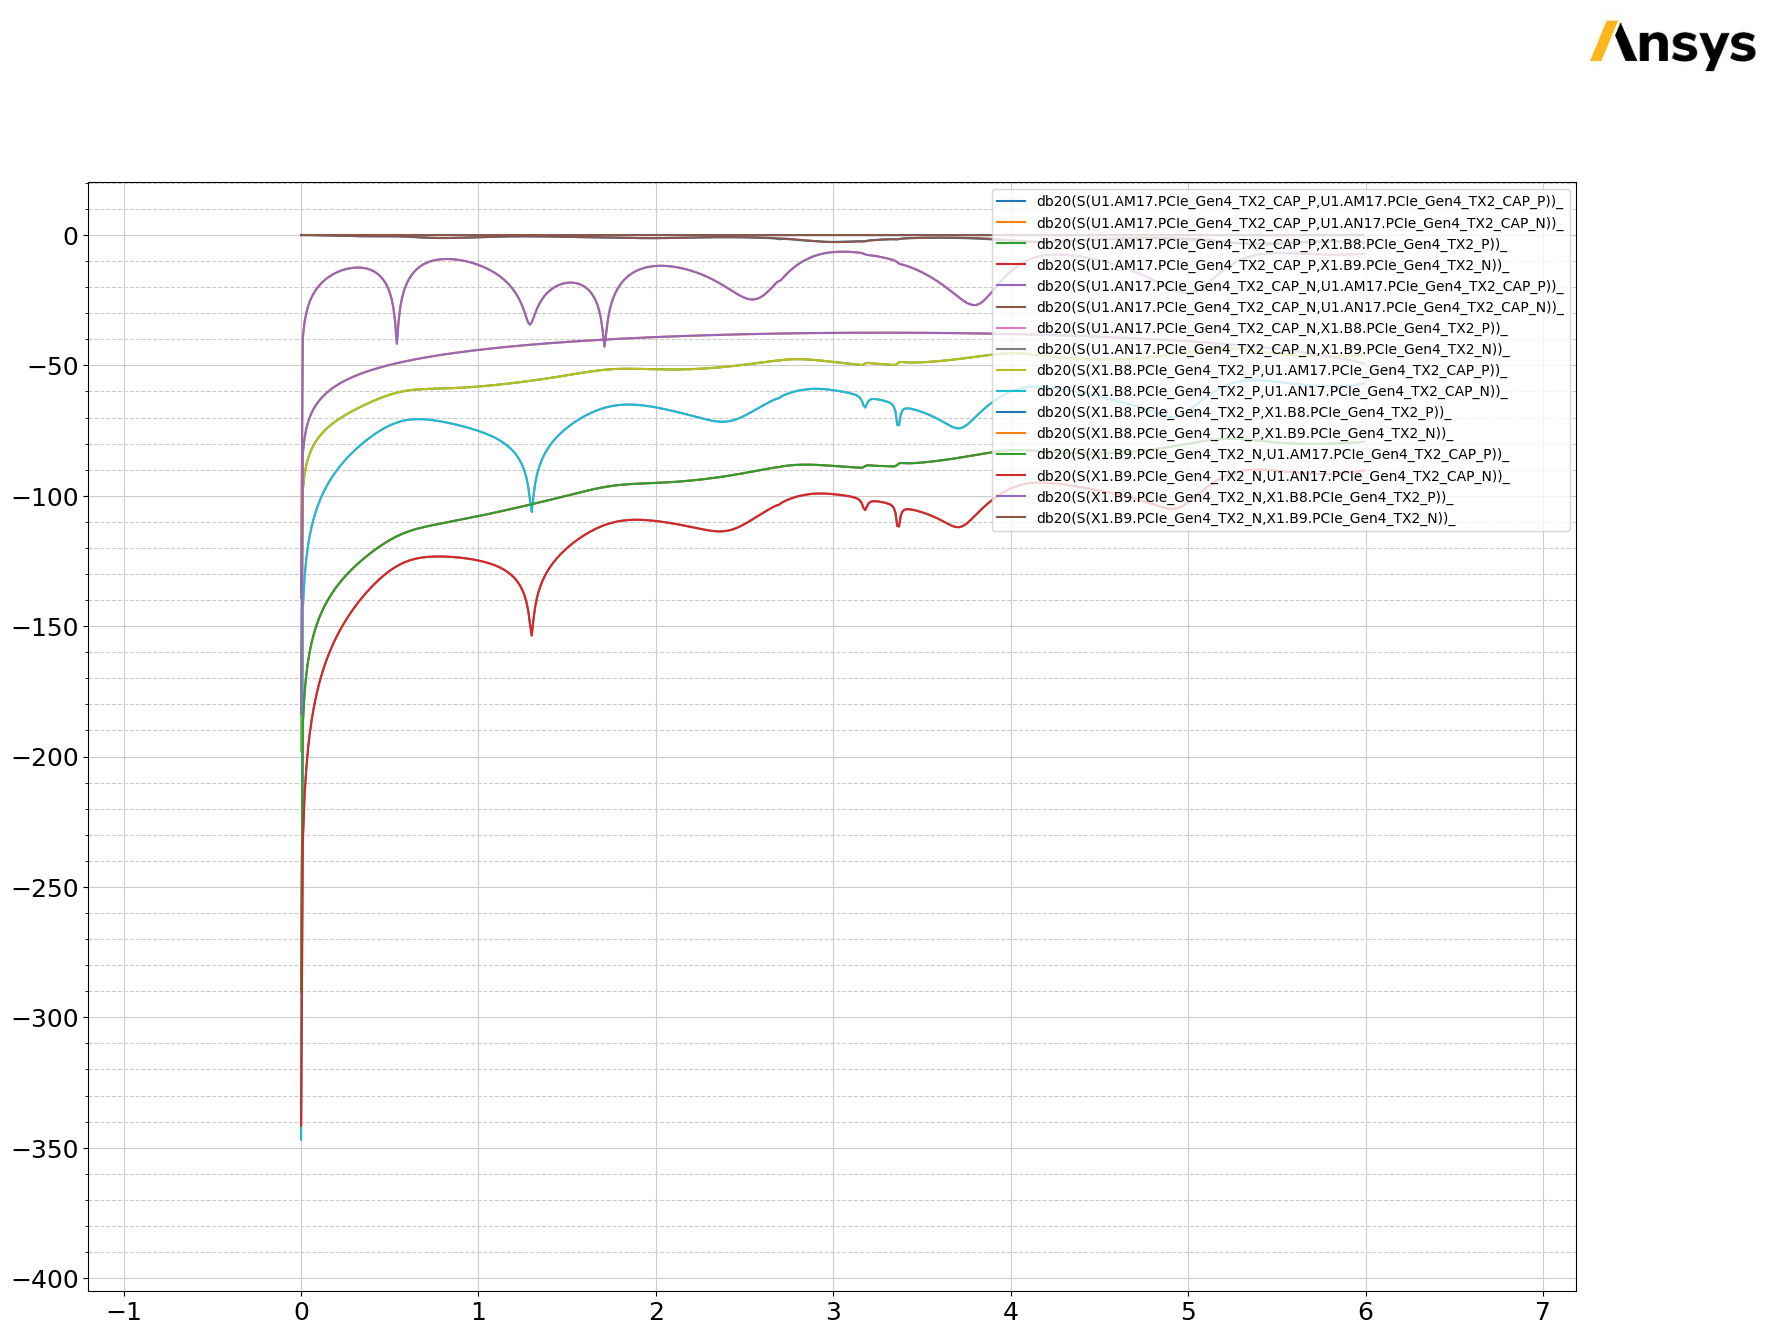

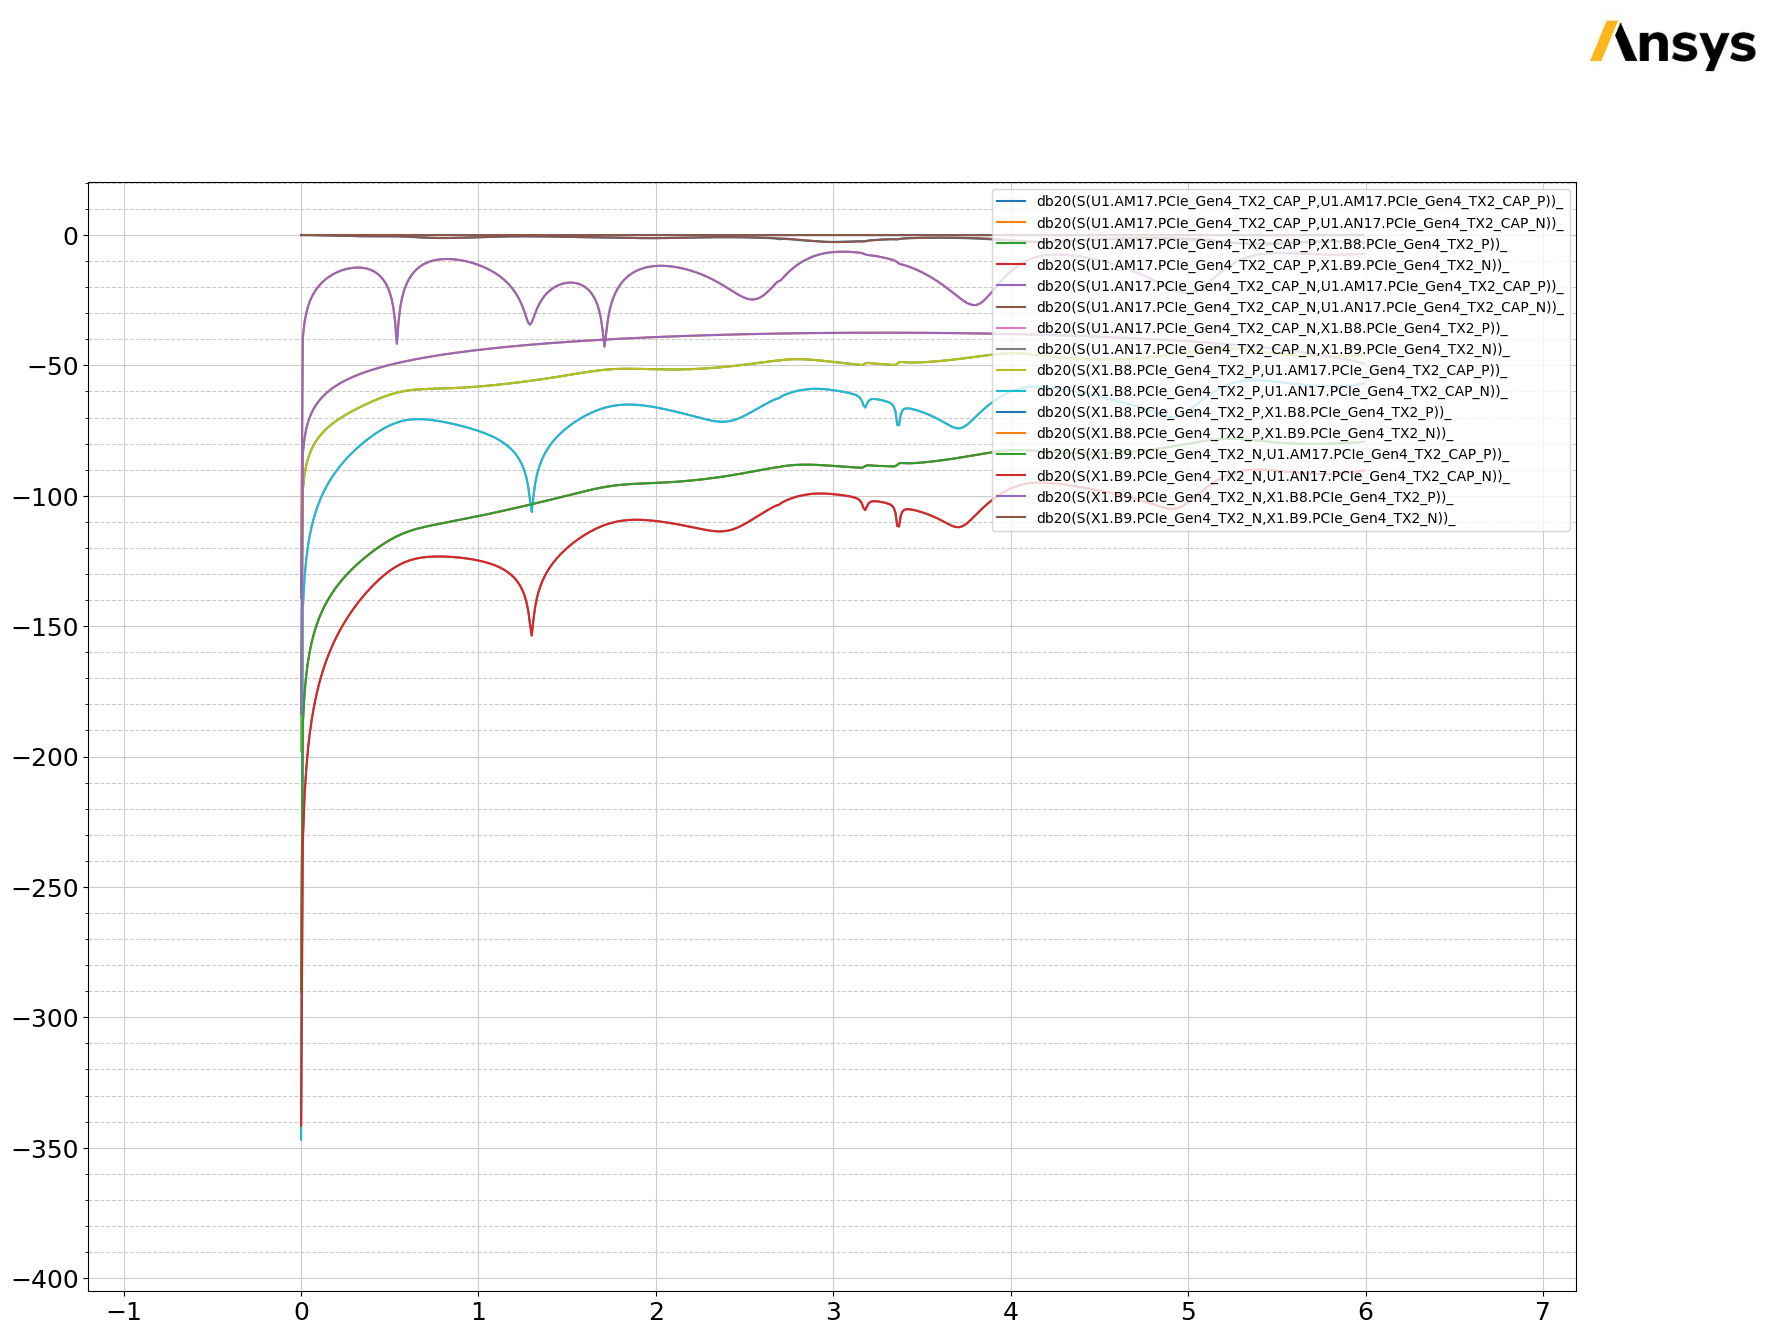

In [16]:
solutions.plot(solutions.expressions, "db20")

## Save and close AEDT

HFSS 3D Layout is saved and closed.

In [17]:
h3d.save_project()
h3d.release_desktop()

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Desktop has been released and closed.


True

Clean up the temporary directory. All files and the temporary project
folder will be deleted in the next step.

In [18]:
temp_dir.cleanup()